### <span style="color:lightgreen">By -</span>
### <span style="color:lightgreen">Anmol Gupta</span>

In [393]:
# Pre-requisite python packages to run the code - 

# !pip install pandas_ta
# !pip install plotly
# !pip install yfinance
# !pip install mplfinance
# !pip install cvxpy
# !pip install PyPortfolioOpt

In [394]:
# Import required libraries

import numpy as np
import pandas as pd

import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import  risk_models
from pypfopt import expected_returns
from pypfopt import objective_functions
from pypfopt.efficient_frontier import EfficientCVaR
from pypfopt import CLA
from pypfopt import plotting


import warnings
pd.options.display.max_columns = 20 
pd.options.display.max_rows = 20
pd.options.display.max_colwidth = 80
np.set_printoptions(precision=4, suppress=True) # Displays only upto 4 decimals

warnings.filterwarnings("ignore", category=FutureWarning) # Suppress specific FutureWarnings

### Defining the list of Stocks taken from different segments - 

Selected from Screener.in, using fundamental analysis on the basis of the following conditions - 

- Market Capitalization > 3000 AND
- Debt to equity <0.5 AND
- Average return on equity 5Years  > 12 AND
- Average return on capital employed 5Years > 12 AND
- EPS growth 5Years > 10 AND
- Pledged percentage  < 10 AND
- Public holding  < 40 AND
- Debt to equity < 1.5 AND
- Sales growth 5Years > 8 AND
- Profit growth 5Years > 8 AND
- Interest Coverage Ratio > 4 AND
- ((Net worth > Net block 3Years back  * 3) OR (Net block + Capital work in progress) > 2* (Net block preceding year + Capital work in progress preceding year ))

In [395]:
# Define the list of stocks based on fundamental analysis
large_cap_stocks = ["INFY.NS", "HAL.NS", "ASIANPAINT.NS", "BEL.NS", "LTIM.NS", "EICHERMOT.NS", "MANKIND.NS", "DRREDDY.NS", "HDFCAMC.NS", "SUNPHARMA.NS", "BAJAJ-AUTO.NS", "ABB.NS", "SHREECEM.NS"]

mid_cap_stocks = ["POLYCAB.NS", "PERSISTENT.NS", "ALKEM.NS", "PIIND.NS", "IRCTC.NS", "TATAELXSI.NS", "SCHAEFFLER.NS", "LTTS.NS"]

small_cap_stocks = ["COFORGE.NS", "KPITTECH.NS", "BLUESTARCO.NS", "KEI.NS", "BASF.NS", "AIAENG.NS", "GODFRYPHLP.NS", "KPRMILL.NS", "POLYMED.NS", "JBCHEPHARM.NS", "RATNAMANI.NS", "LALPATHLAB.NS", "GRINDWELL.NS", "CAMS.NS", "AFFLE.NS", "TRITURBINE.NS", "JWL.NS", "IRCON.NS", "NEWGEN.NS", "GRSE.NS", "ANANDRATHI.NS", "ZENTEC.NS", "BLS.NS"]

In [396]:
# Date for which we are analyzing (which is the same day for when we have to invest all available equity)
analysis_date = "2023-10-18"

In [397]:
# Define the weights for each indicator
weight_rsi = 0.45
weight_ma = 0.3
weight_macd = 0.35

In [398]:
# Function to calculate indicators and combined signal for a stock
def calculate_monthly_signals(stock, analysis_date):
    # Download stock data with a buffer around the analysis date for indicator calculations
    data = yf.download(stock, start="2013-10-01", end=analysis_date, interval="1wk")

    # Check if data is available and find the last available date
    if data.empty:
        print(f"No data available for {stock}")
        return None

    # Get the most recent available date for analysis
    last_available_date = data.index[-1].strftime('%Y-%m-%d')
    print(f"Using last available date {last_available_date} for {stock}")

    # Calculate indicators

    # First indicator we calculate is the Moving Average Crossover
    data['MA20'] = data['Adj Close'].rolling(window=20).mean()  # 20-day Simple Moving Average
    data['MA50'] = data['Adj Close'].rolling(window=50).mean()  # 50-day Simple Moving Average
    data['MA20-MA50'] = data['MA20'] - data['MA50']  # Increasing condition for momentum

    # Second indicator we calculate is the Relative Strength Index
    data['RSI'] = 100 - (100 / (1 + data['Adj Close'].pct_change().rolling(14).apply(lambda x: (x[x > 0].sum() / -x[x < 0].sum()) if x[x < 0].sum() != 0 else 0, raw=True)))

    # Third Indicator - Manual MACD calculation
    data['EMA12'] = data['Adj Close'].ewm(span=12, adjust=False).mean()  # 12-day EMA
    data['EMA26'] = data['Adj Close'].ewm(span=26, adjust=False).mean()  # 26-day EMA
    data['MACD'] = data['EMA12'] - data['EMA26']  # MACD Line
    data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()  # Signal Line
    
    # Fourth indicator we calculate is the Moving Average (Golden) Crossover [Removed from code as it did not contribute anything to the stocks selected]
    # data['MA200'] = data['Adj Close'].rolling(window=200).mean()  # 200-day Simple Moving Average
    # data['MA50'] = data['Adj Close'].rolling(window=50).mean()  # 50-day Simple Moving Average
    # data['MA200-MA50'] = data['MA50'] - data['MA200']  # Crossover condition


    # Extract indicator values on the most recent available date
    def get_scalar_value(column):
        """ Helper function to get a scalar from a potential Series or scalar """
        value = data.loc[last_available_date, column]
        return value.iloc[0] if isinstance(value, pd.Series) else value
    
    rsi_value = get_scalar_value('RSI')
    ma20_value = get_scalar_value('MA20')
    ma50_value = get_scalar_value('MA50')
    macd_value = get_scalar_value('MACD')
    macd_signal_value = get_scalar_value('MACD_Signal')

    # ma200_value = get_scalar_value('MA200')
    ma50_value = get_scalar_value('MA50')
    
    # Calculate scores based on the extracted values
    gc_score = 0 # By default
    ma_score = 0 # By default

    # Giving a score of 1 to the Moving Average indicator if the 20-week MA is greater than the 50-day MA and there is a deviation noticed in the two values
    # ma_score = 1 if ma20_value > ma50_value else 0
    if data['MA20-MA50'][::-1][0] > 0:
        if data['MA20-MA50'][::-1][1] > data['MA20-MA50'][::-1][2]:
            if data['MA20-MA50'][::-1][0] > data['MA20-MA50'][::-1][1]:
                ma_score = 1

    # Giving a score of 1 to the (Golden Crossover) Moving Average indicator if the 50 Wk MA crosser over the 200 Wk MA
    # if data['MA200-MA50'][::-1][2] < 0 and data['MA200-MA50'][::-1][0] > 0:
    #     if data['MA200-MA50'][::-1][1] > data['MA200-MA50'][::-1][2]:
    #         if data['MA200-MA50'][::-1][0] > data['MA200-MA50'][::-1][1]:
    #             gc_score = 1

    # Calculate the RSI Score if the RSI Value is < 35 (i.e., the stock is oversold)
    rsi_score = 1 if rsi_value < 35 else 0
    # Calculate the MACD Score if the MACD Value is greater than the MACD Signal 
    macd_score = 1 if macd_value > macd_signal_value else 0
    
    # Return all values in a dictionary format for easy appending to DataFrame
    stock_with_indicator = {
        "Stock": stock,
        "Date_Used": last_available_date,
        "RSI(W)": rsi_value,
        "RSI_Score": rsi_score,
        "MA20(W)": ma20_value,
        "MA50(W)": ma50_value,
        "MA_Score": ma_score,
        "MACD(W)": macd_value,
        "MACD_Signal": macd_signal_value,
        "MACD_Score": macd_score,
        # "MA200(W)": ma200_value,
        # "MA50(W)": ma50_value,
        # "GC_Score": gc_score,
    }
    
    return stock_with_indicator

In [399]:
results = pd.DataFrame()

# Loop through each stock in the Large/Mid/Small-cap segment list and calculate the combined buy signal for the most recent available date
for segment, stock_segment in enumerate([large_cap_stocks, mid_cap_stocks, small_cap_stocks]):
    for stock in stock_segment:
        monthly_indicators = calculate_monthly_signals(stock, analysis_date)
        
        all_stock_indicators = {**monthly_indicators}

        # Calculate the combined buy signal on the basis of the weights of the indicators defined above
        # all_stock_indicators['combined_buy_signal'] = (all_stock_indicators['RSI_Score'] * weight_rsi) + (all_stock_indicators['MA_Score'] * weight_ma) + (all_stock_indicators['MACD_Score'] * weight_macd) + (all_stock_indicators['GC_Score'] * weight_gc)
        all_stock_indicators['combined_buy_signal'] = (all_stock_indicators['RSI_Score'] * weight_rsi) + (all_stock_indicators['MA_Score'] * weight_ma) + (all_stock_indicators['MACD_Score'] * weight_macd)
        all_stock_indicators['segment'] = segment
        if all_stock_indicators is not None:
            # Append the result to the DataFrame
            results = pd.concat([results, pd.DataFrame([all_stock_indicators])], ignore_index=True)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Using last available date 2023-10-16 for INFY.NS
Using last available date 2023-10-16 for HAL.NS


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed

Using last available date 2023-10-16 for ASIANPAINT.NS



[*********************100%%**********************]  1 of 1 completed


Using last available date 2023-10-16 for BEL.NS
Using last available date 2023-10-16 for LTIM.NS


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Using last available date 2023-10-16 for EICHERMOT.NS
Using last available date 2023-10-16 for MANKIND.NS


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Using last available date 2023-10-16 for DRREDDY.NS
Using last available date 2023-10-16 for HDFCAMC.NS


[*********************100%%**********************]  1 of 1 completed


Using last available date 2023-10-16 for SUNPHARMA.NS


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Using last available date 2023-10-16 for BAJAJ-AUTO.NS


Using last available date 2023-10-16 for ABB.NS


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Using last available date 2023-10-16 for SHREECEM.NS
Using last available date 2023-10-16 for POLYCAB.NS


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Using last available date 2023-10-16 for PERSISTENT.NS
Using last available date 2023-10-16 for ALKEM.NS


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Using last available date 2023-10-16 for PIIND.NS
Using last available date 2023-10-16 for IRCTC.NS


[*********************100%%**********************]  1 of 1 completed


Using last available date 2023-10-16 for TATAELXSI.NS


[*********************100%%**********************]  1 of 1 completed


Using last available date 2023-10-16 for SCHAEFFLER.NS


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Using last available date 2023-10-16 for LTTS.NS
Using last available date 2023-10-16 for COFORGE.NS


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Using last available date 2023-10-16 for KPITTECH.NS



[*********************100%%**********************]  1 of 1 completed


Using last available date 2023-10-16 for BLUESTARCO.NS
Using last available date 2023-10-16 for KEI.NS


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Using last available date 2023-10-16 for BASF.NS


Using last available date 2023-10-16 for AIAENG.NS


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Using last available date 2023-10-16 for GODFRYPHLP.NS



[*********************100%%**********************]  1 of 1 completed

Using last available date 2023-10-16 for KPRMILL.NS


Using last available date 2023-10-16 for POLYMED.NS


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Using last available date 2023-10-16 for JBCHEPHARM.NS


Using last available date 2023-10-16 for RATNAMANI.NS


[*********************100%%**********************]  1 of 1 completed


Using last available date 2023-10-16 for LALPATHLAB.NS


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Using last available date 2023-10-16 for GRINDWELL.NS



[*********************100%%**********************]  1 of 1 completed


Using last available date 2023-10-16 for CAMS.NS
Using last available date 2023-10-16 for AFFLE.NS


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Using last available date 2023-10-16 for TRITURBINE.NS
Using last available date 2023-10-16 for JWL.NS


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Using last available date 2023-10-16 for IRCON.NS
Using last available date 2023-10-16 for NEWGEN.NS


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Using last available date 2023-10-16 for GRSE.NS
Using last available date 2023-10-16 for ANANDRATHI.NS


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Using last available date 2023-10-16 for ZENTEC.NS
Using last available date 2023-10-16 for BLS.NS


In [400]:
results

,Stock,Date_Used,RSI(W),RSI_Score,MA20(W),MA50(W),MA_Score,MACD(W),MACD_Signal,MACD_Score,combined_buy_signal,segment
0,INFY.NS,2023-10-16,52.444919,0,1340.306110,1366.779165,0,22.340923,13.397663,1,0.35,0
1,HAL.NS,2023-10-16,55.873803,0,1904.968762,1555.231780,1,117.080119,136.029498,0,0.30,0
2,ASIANPAINT.NS,2023-10-16,32.527018,1,3229.904126,3029.313745,0,19.854240,50.637531,0,0.45,0
3,BEL.NS,2023-10-16,61.723794,0,129.501495,111.094658,1,7.956419,8.295468,0,0.30,0
4,LTIM.NS,2023-10-16,54.123810,0,5039.552344,4710.414658,0,132.770773,150.465801,0,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...
39,NEWGEN.NS,2023-10-16,81.936237,0,409.030629,296.220026,1,55.080874,50.532639,1,0.65,2
40,GRSE.NS,2023-10-16,73.206508,0,689.136772,552.004609,1,86.955145,83.090114,1,0.65,2
41,ANANDRATHI.NS,2023-10-16,92.991965,0,1299.361911,984.795104,1,247.899187,190.966423,1,0.65,2
42,ZENTEC.NS,2023-10-16,66.517948,0,652.793306,412.919940,1,105.368401,116.947151,0,0.30,2


In [401]:
# Assigning friendly name to the segment
results.loc[results.segment == 0,'segment'] = 'Large-Cap'
results.loc[results.segment == 1,'segment'] = 'Mid-Cap'
results.loc[results.segment == 2,'segment'] = 'Small-Cap'

In [402]:
# Remove duplicate rows, keeping only the latest data for each stock
results = results.drop_duplicates(subset=["Stock"], keep="first")
results

,Stock,Date_Used,RSI(W),RSI_Score,MA20(W),MA50(W),MA_Score,MACD(W),MACD_Signal,MACD_Score,combined_buy_signal,segment
0,INFY.NS,2023-10-16,52.444919,0,1340.306110,1366.779165,0,22.340923,13.397663,1,0.35,Large-Cap
1,HAL.NS,2023-10-16,55.873803,0,1904.968762,1555.231780,1,117.080119,136.029498,0,0.30,Large-Cap
2,ASIANPAINT.NS,2023-10-16,32.527018,1,3229.904126,3029.313745,0,19.854240,50.637531,0,0.45,Large-Cap
3,BEL.NS,2023-10-16,61.723794,0,129.501495,111.094658,1,7.956419,8.295468,0,0.30,Large-Cap
4,LTIM.NS,2023-10-16,54.123810,0,5039.552344,4710.414658,0,132.770773,150.465801,0,0.00,Large-Cap
...,...,...,...,...,...,...,...,...,...,...,...,...
39,NEWGEN.NS,2023-10-16,81.936237,0,409.030629,296.220026,1,55.080874,50.532639,1,0.65,Small-Cap
40,GRSE.NS,2023-10-16,73.206508,0,689.136772,552.004609,1,86.955145,83.090114,1,0.65,Small-Cap
41,ANANDRATHI.NS,2023-10-16,92.991965,0,1299.361911,984.795104,1,247.899187,190.966423,1,0.65,Small-Cap
42,ZENTEC.NS,2023-10-16,66.517948,0,652.793306,412.919940,1,105.368401,116.947151,0,0.30,Small-Cap


In [403]:
# Dividing all stock results and their technical indicators back into segments so that the best stocks can be bought per Stock segment
large_cap_results = results.loc[results.segment == 'Large-Cap']
mid_cap_results = results.loc[results.segment == 'Mid-Cap']
small_cap_results = results.loc[results.segment == 'Small-Cap']
large_cap_results

,Stock,Date_Used,RSI(W),RSI_Score,MA20(W),MA50(W),MA_Score,MACD(W),MACD_Signal,MACD_Score,combined_buy_signal,segment
0,INFY.NS,2023-10-16,52.444919,0,1340.306110,1366.779165,0,22.340923,13.397663,1,0.35,Large-Cap
1,HAL.NS,2023-10-16,55.873803,0,1904.968762,1555.231780,1,117.080119,136.029498,0,0.30,Large-Cap
2,ASIANPAINT.NS,2023-10-16,32.527018,1,3229.904126,3029.313745,0,19.854240,50.637531,0,0.45,Large-Cap
3,BEL.NS,2023-10-16,61.723794,0,129.501495,111.094658,1,7.956419,8.295468,0,0.30,Large-Cap
4,LTIM.NS,2023-10-16,54.123810,0,5039.552344,4710.414658,0,132.770773,150.465801,0,0.00,Large-Cap
5,EICHERMOT.NS,2023-10-16,72.060877,0,3360.247046,3263.307080,0,43.306279,36.396853,1,0.35,Large-Cap
6,MANKIND.NS,2023-10-16,49.148488,0,1764.987512,NaN,0,75.979540,87.068516,0,0.00,Large-Cap
7,DRREDDY.NS,2023-10-16,65.990750,0,1052.315649,940.605612,1,44.863305,51.110211,0,0.30,Large-Cap
8,HDFCAMC.NS,2023-10-16,71.236084,0,2416.929059,2077.043022,1,213.739240,185.209738,1,0.65,Large-Cap
9,SUNPHARMA.NS,2023-10-16,67.428314,0,1087.959644,1022.561647,1,39.501939,38.737485,1,0.65,Large-Cap


In [404]:
# Calculating and printing the normalized buy signal as well as providing Ranks to the segment-wise Stocks on the basis of this normalized buy signal
for results in [large_cap_results, mid_cap_results, small_cap_results]:
    # Normalize the combined buy signals to a range of 0 to 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    results['Normalized_Buy_Signal'] = scaler.fit_transform(results[['combined_buy_signal']])
    # Rank the stocks based on the normalized buy signal (1 = strongest buy, 0 = weakest buy)
    results['Rank'] = results['Normalized_Buy_Signal'].rank(ascending=False, method='dense')
    # Sorting the Segment-wise stocks on the basis of Rank, MACD Score and RSI
    results = results.sort_values(by=['Rank', 'MACD_Score', 'RSI(W)'], ascending=[True, False, True])
    # Display the results with rankings
    print(f"\nRanked {results.reset_index()['segment'][0]} stocks based on combined indicator signals:")
    print(results[['segment', 'Stock', 'Date_Used', 'RSI(W)', 'RSI_Score', 'MA20(W)', 'MA50(W)', 'MACD(W)', 'MACD_Score', 'MA_Score',
                'combined_buy_signal', 'Normalized_Buy_Signal', 'Rank']][:12])


Ranked Large-Cap stocks based on combined indicator signals:
      segment          Stock   Date_Used     RSI(W)  RSI_Score       MA20(W)  \
9   Large-Cap   SUNPHARMA.NS  2023-10-16  67.428314          0   1087.959644   
8   Large-Cap     HDFCAMC.NS  2023-10-16  71.236084          0   2416.929059   
2   Large-Cap  ASIANPAINT.NS  2023-10-16  32.527018          1   3229.904126   
0   Large-Cap        INFY.NS  2023-10-16  52.444919          0   1340.306110   
10  Large-Cap  BAJAJ-AUTO.NS  2023-10-16  61.380691          0   4757.904517   
12  Large-Cap    SHREECEM.NS  2023-10-16  64.205625          0  24883.485059   
5   Large-Cap   EICHERMOT.NS  2023-10-16  72.060877          0   3360.247046   
1   Large-Cap         HAL.NS  2023-10-16  55.873803          0   1904.968762   
3   Large-Cap         BEL.NS  2023-10-16  61.723794          0    129.501495   
7   Large-Cap     DRREDDY.NS  2023-10-16  65.990750          0   1052.315649   
11  Large-Cap         ABB.NS  2023-10-16  42.751110       

C:\Users\anmol\AppData\Local\Temp\ipykernel_17700\2975723746.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\anmol\AppData\Local\Temp\ipykernel_17700\2975723746.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\anmol\AppData\Local\Temp\ipykernel_17700\2975723746.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

## Ranked Stocks Based on Combined Indicator Signals

- We have tried to opt for stocks where the combined_buy_signal, based on the different indicators (RSI, MACD and Moving Averages) selected was greater than 0.35

### Top Stocks for Large-cap, based on Potential Buy Signals:

- **SUNPHARMA.NS & HDFCAMC.NS (Rank 1.00)**: Both show a strong **Combined Buy Signal** of 0.65, driven by a strong **MACD** and **Moving Average** score (both 1). Even though their RSI value is nearing overbought levels, the weekly level granularity suggests positive momentum in the forseeable future but caution for potential pullbacks.
- **ASIANPAINT.NS (Rank 2.00)**: With an **RSI Value** of 32 (indicating it’s close to the oversold level) this stock is bound to rebound.
- **INFY.NS, BAJAJ.NS and SHREECEM.NS (Rank 3.00)**: These three stocks show positive **MACD Scores**, meaning they are above their longer-term moving averages, suggesting a strong trend. The reason **EICHERMOT.NS** was left out was due to it being above the oversold levels based on its **RSI Score**

### Top Stocks for Mid-cap, based on Potential Buy Signals:

- **LTTS.NS, IRCTC.NS & POLYCAB.NS (Rank 1.00)**: These three stocks shows a **Combined Buy Signal** of 0.65, driven by a strong **MACD** and **Moving Average** score (both 1), indicating it could be a strong candidate. The **RSI(W)** is near to or exceeding the overbought levels, suggesting positive momentum in the forseeable future but caution for potential pullbacks.
- **TATAELXSI.NS & PERSISTENT.NS (Rank 2.00)**: With an **MACD_Score** of 1, both appear strong. In addition **TATAELXSI.NS** has a favorable RSI Score as well.

### Top Stocks for Small-cap, based on Potential Buy Signals:

- **JBCHEMPHARM.NS, LALPATHLAB.NS, CAMS.NS, BLUESTARCO.NS & GRSE.NS (Rank 1.00)**: All these stocks show a **Combined Buy Signal** of 0.65, driven by a strong **MACD** and **Moving Average** score (both 1), indicating it could be a strong candidate. The **RSI(W)** is near to or exceeding the overbought levels, suggesting positive momentum in the forseeable future but caution for potential pullbacks. The reason to select only 6 stocks is keeping in mind the Risk Profile we have opted for.

In [405]:
# Based on weekly technical indicators, we have the selected the following stocks as the consitutents of the final portfolio which will be backtested 
final_portfolio = large_cap_results.loc[large_cap_results['Stock'].isin(['ASIANPAINT.NS', 'SUNPHARMA.NS', 'HDFCAMC.NS', 'INFY.NS', 'BAJAJ-AUTO.NS', 'SHREECEM.NS', 'EICHERMOT.NS'])]
final_portfolio = pd.concat([final_portfolio, mid_cap_results.loc[mid_cap_results['Stock'].isin(['LTTS.NS', 'IRCTC.NS', 'POLYCAB.NS', 'TATAELXSI.NS', 'PERSISTENT.NS'])]], ignore_index=True) 
final_portfolio = pd.concat([final_portfolio, small_cap_results.loc[small_cap_results['Stock'].isin(['JBCHEPHARM.NS', 'LALPATHLAB.NS', 'CAMS.NS', 'BLUESTARCO.NS', 'GRSE.NS'])]], ignore_index=True) 
final_portfolio

,Stock,Date_Used,RSI(W),RSI_Score,MA20(W),MA50(W),MA_Score,MACD(W),MACD_Signal,MACD_Score,combined_buy_signal,segment,Normalized_Buy_Signal,Rank
0,INFY.NS,2023-10-16,52.444919,0,1340.306110,1366.779165,0,22.340923,13.397663,1,0.35,Large-Cap,0.538462,3.0
1,ASIANPAINT.NS,2023-10-16,32.527018,1,3229.904126,3029.313745,0,19.854240,50.637531,0,0.45,Large-Cap,0.692308,2.0
2,EICHERMOT.NS,2023-10-16,72.060877,0,3360.247046,3263.307080,0,43.306279,36.396853,1,0.35,Large-Cap,0.538462,3.0
3,HDFCAMC.NS,2023-10-16,71.236084,0,2416.929059,2077.043022,1,213.739240,185.209738,1,0.65,Large-Cap,1.000000,1.0
4,SUNPHARMA.NS,2023-10-16,67.428314,0,1087.959644,1022.561647,1,39.501939,38.737485,1,0.65,Large-Cap,1.000000,1.0
5,BAJAJ-AUTO.NS,2023-10-16,61.380691,0,4757.904517,4176.253203,0,234.191866,228.115982,1,0.35,Large-Cap,0.538462,3.0
6,SHREECEM.NS,2023-10-16,64.205625,0,24883.485059,24544.501289,0,533.100342,296.997429,1,0.35,Large-Cap,0.538462,3.0
7,POLYCAB.NS,2023-10-16,87.224487,0,4567.930359,3567.190679,1,543.009019,522.480879,1,0.65,Mid-Cap,1.000000,1.0
8,PERSISTENT.NS,2023-10-16,72.402171,0,2604.855823,2361.911731,0,161.519195,142.640705,1,0.35,Mid-Cap,0.538462,2.0
9,IRCTC.NS,2023-10-16,66.248407,0,657.395074,640.552087,1,18.752206,13.205526,1,0.65,Mid-Cap,1.000000,1.0


In [406]:
# Pulling Daily data for each stock in the final portfolio
portfolio_daily_data=yf.download(tickers=list(final_portfolio['Stock']),start="2013-10-01",end="2023-10-18",interval="1d")['Adj Close']
portfolio_daily_data

# Dropping all days where the price for any of the stocks was null or undefined
portfolio_daily_data.dropna(how='any',inplace=True)

[******                12%%                      ]  2 of 17 completed

[*********************100%%**********************]  17 of 17 completed


In [407]:
# Calculating the number of stocks in our portfolio
numstocks = len(final_portfolio['Stock'])

StockReturns=pd.DataFrame()
StockReturns=portfolio_daily_data.iloc[-252:,0:numstocks].pct_change() # Looking at only the last 1 year (255 Trading days) worth of data for backtesting our portfolio's returns

In [408]:
# Dropping all days where the Returns for any of the stocks was null or undefined
StockReturns.dropna(how='any',inplace=True)
StockReturns

Ticker,ASIANPAINT.NS,BAJAJ-AUTO.NS,BLUESTARCO.NS,CAMS.NS,EICHERMOT.NS,GRSE.NS,HDFCAMC.NS,INFY.NS,IRCTC.NS,JBCHEPHARM.NS,LALPATHLAB.NS,LTTS.NS,PERSISTENT.NS,POLYCAB.NS,SHREECEM.NS,SUNPHARMA.NS,TATAELXSI.NS
Date,,,,,,,,,,,,,,,,,
2022-10-13,-0.012068,-0.005435,-0.028293,0.011354,0.003759,0.022930,-0.002493,-0.006159,0.002492,-0.013722,0.023962,-0.008841,-0.022433,-0.000446,0.003022,0.013448,-0.005717
2022-10-14,-0.007323,-0.009515,0.021192,-0.007953,0.001728,-0.021469,-0.012160,0.038277,-0.001726,-0.000440,0.007928,0.014979,0.037180,-0.001612,0.005355,0.008158,0.018369
2022-10-17,0.003798,0.016384,0.024911,0.008773,0.010785,-0.060551,0.009226,0.010649,0.007124,-0.009495,0.008454,-0.008858,-0.005141,0.018810,-0.016868,0.003790,-0.080650
2022-10-18,0.008835,-0.004877,0.013638,-0.001886,0.027826,0.044648,0.010369,0.009228,0.004327,0.008568,0.018977,0.024747,0.016880,0.049737,0.006567,-0.001684,-0.074286
2022-10-19,-0.004061,0.012336,0.004333,-0.010969,-0.000055,0.017315,0.013494,-0.012137,0.015934,-0.005387,0.011481,-0.048992,-0.007412,-0.015424,0.016983,-0.001482,0.015205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-11,0.003935,0.005340,0.019294,0.000663,0.008052,0.003494,-0.005826,-0.000502,-0.001559,0.015943,0.005399,-0.006219,0.000660,0.004428,0.012903,0.001997,-0.006019
2023-10-12,-0.001517,0.008333,-0.004080,0.061198,0.002180,-0.003482,0.003003,-0.019339,-0.006174,-0.015726,0.021001,-0.005417,0.001823,0.002448,0.005741,0.001462,0.005495
2023-10-13,-0.003260,-0.010614,-0.005918,-0.016485,-0.005094,-0.003244,0.036310,-0.023439,0.005569,-0.012178,-0.000059,-0.000476,-0.001040,0.015684,0.007416,0.013181,0.012025


In [409]:
equal_weightage=np.repeat(1/numstocks, numstocks) # Defining the weights for the equal weighted portfolio
StockReturns.describe()

Ticker,ASIANPAINT.NS,BAJAJ-AUTO.NS,BLUESTARCO.NS,CAMS.NS,EICHERMOT.NS,GRSE.NS,HDFCAMC.NS,INFY.NS,IRCTC.NS,JBCHEPHARM.NS,LALPATHLAB.NS,LTTS.NS,PERSISTENT.NS,POLYCAB.NS,SHREECEM.NS,SUNPHARMA.NS,TATAELXSI.NS
count,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000
mean,-0.000079,0.001592,0.001908,0.000177,0.000196,0.002806,0.001898,0.000244,0.000082,0.001674,0.000590,0.001189,0.002048,0.003185,0.001078,0.000785,-0.000324
std,0.010699,0.012563,0.016258,0.013246,0.014387,0.033820,0.018584,0.014675,0.013431,0.018371,0.018467,0.017451,0.018495,0.017937,0.015361,0.009876,0.014619
min,-0.040438,-0.054572,-0.045168,-0.035956,-0.063084,-0.106335,-0.049127,-0.094227,-0.062390,-0.044690,-0.083592,-0.062977,-0.058320,-0.076322,-0.057391,-0.036306,-0.080650
25%,-0.005051,-0.005662,-0.007229,-0.007871,-0.007410,-0.013552,-0.007526,-0.007873,-0.005268,-0.008881,-0.010107,-0.008471,-0.009738,-0.007141,-0.006853,-0.005401,-0.007247
50%,0.000481,0.000413,0.000674,-0.000022,-0.000194,-0.001026,0.001051,0.001021,0.000622,-0.000305,0.000184,0.000574,0.000642,0.002524,0.002166,-0.000090,-0.000061
75%,0.006062,0.007918,0.008594,0.006081,0.009511,0.015261,0.009310,0.008436,0.006209,0.009848,0.010639,0.009202,0.012045,0.013156,0.009578,0.006802,0.005830
max,0.032337,0.059036,0.134054,0.061198,0.064914,0.180684,0.119829,0.045374,0.038969,0.070206,0.070580,0.090410,0.075399,0.094805,0.063473,0.029164,0.071099


### Equal weighted Portfolio

Calculate the equally-weighted portfolio returns (for the latest 1 year period)

In [410]:
EWPortfolio=pd.DataFrame()
EWPortfolio['Portfolio_EW_Returns'] = StockReturns.iloc[-252:, 0:numstocks].mul(equal_weightage,axis=1).sum(axis=1)
EWPortfolio

,Portfolio_EW_Returns
Date,
2022-10-13,-0.001450
2022-10-14,0.005351
2022-10-17,-0.003462
2022-10-18,0.009507
2022-10-19,0.000068
...,...
2023-10-11,0.003646
2023-10-12,0.003350
2023-10-13,0.000493


Equal Weightage Portfolio


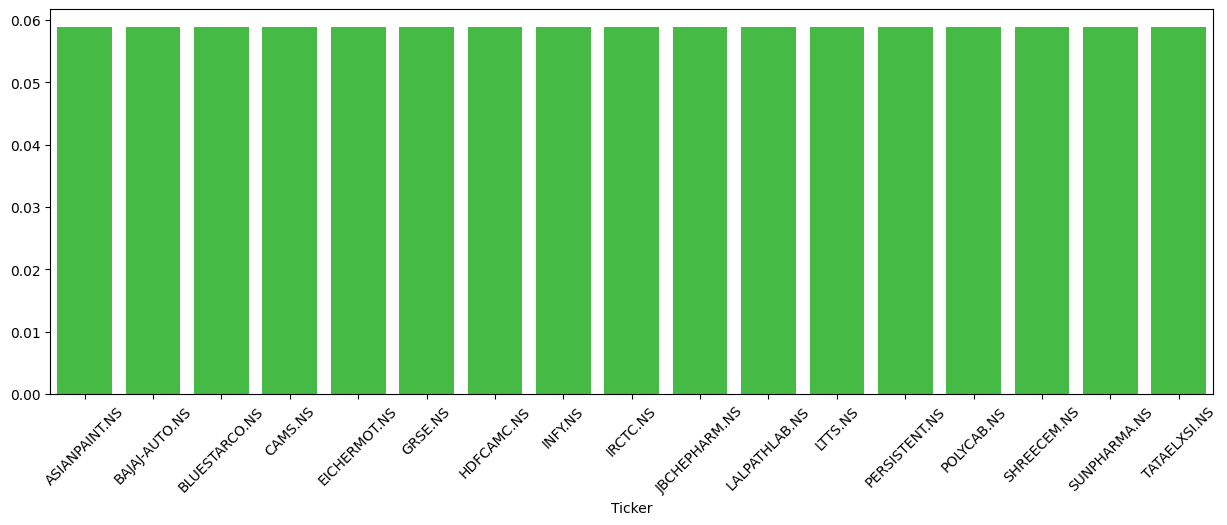

In [411]:
# Representing the weights in the form of a barplot
fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(x=StockReturns.columns ,y=equal_weightage , color= "limegreen")
print('Equal Weightage Portfolio')
plt.xticks(rotation=45)
plt.show(fig)

In [412]:
# Returns from the Equally weighted portfolio
EWPortfolio['Portfolio_EW_Returns']

Date
2022-10-13   -0.001450
2022-10-14    0.005351
2022-10-17   -0.003462
2022-10-18    0.009507
2022-10-19    0.000068
                ...   
2023-10-11    0.003646
2023-10-12    0.003350
2023-10-13    0.000493
2023-10-16   -0.000640
2023-10-17    0.004730
Name: Portfolio_EW_Returns, Length: 251, dtype: float64

In [413]:
# Assume an annual risk-free rate of 2% (adjust for your specific rate)
risk_free_rate_annual = 0.02
risk_free_rate_daily = risk_free_rate_annual / 252  # Approximate daily risk-free rate, based on 252 trading days in a year

In [414]:
# Calculate the portfolio returns, risk and SHARPE Ratio for the latest 1 year period
print("Portfolio expected return:",EWPortfolio.mean()*252)
print("Portfolio standard deviation/Risk:",EWPortfolio.std())

EWPortfolio['Portfolio_EW_Excess_Returns'] = EWPortfolio['Portfolio_EW_Returns'] - risk_free_rate_daily

# Calculate Sharpe Ratio
average_excess_return = EWPortfolio['Portfolio_EW_Excess_Returns'].mean()
portfolio_volatility = EWPortfolio['Portfolio_EW_Returns'].std()

# Annualize the Sharpe Ratio (assuming 252 trading days)
ew_sharpe_ratio = (average_excess_return / portfolio_volatility) * np.sqrt(252)
print("Portfolio Annualized SHARPE Ratio:",ew_sharpe_ratio)

Portfolio expected return: Portfolio_EW_Returns    0.282356
dtype: float64
Portfolio standard deviation/Risk: Portfolio_EW_Returns    0.007071
dtype: float64
Portfolio Annualized SHARPE Ratio: 2.3372812613989162


In [415]:
# Defining a new array which will store results from all backtesting strategies which we can compare at the end
all_portfolios_backtest = []

# Appending the results of the Equal Weight Portfolio to the all_ portfolios_backtest array
all_portfolios_backtest.append(['Equal Weightage Portfolio', EWPortfolio.mean()[0]*252, EWPortfolio.std()[0], ew_sharpe_ratio])
all_portfolios_backtest

[['Equal Weightage Portfolio',
  0.2823560796936469,
  0.007070984498090585,
  2.3372812613989162]]

In [416]:
# calculating returns from pypfopt module
# portfolio_returns=expected_returns.returns_from_prices(portfolio_monthly_data[-12:], log_returns=False)
portfolio_returns=expected_returns.returns_from_prices(portfolio_daily_data[-252:], log_returns=False) # Calculating simple returns of the overall portfolio but only for the last 252 trading days
portfolio_returns

Ticker,ASIANPAINT.NS,BAJAJ-AUTO.NS,BLUESTARCO.NS,CAMS.NS,EICHERMOT.NS,GRSE.NS,HDFCAMC.NS,INFY.NS,IRCTC.NS,JBCHEPHARM.NS,LALPATHLAB.NS,LTTS.NS,PERSISTENT.NS,POLYCAB.NS,SHREECEM.NS,SUNPHARMA.NS,TATAELXSI.NS
Date,,,,,,,,,,,,,,,,,
2022-10-13,-0.012068,-0.005435,-0.028293,0.011354,0.003759,0.022930,-0.002493,-0.006159,0.002492,-0.013722,0.023962,-0.008841,-0.022433,-0.000446,0.003022,0.013448,-0.005717
2022-10-14,-0.007323,-0.009515,0.021192,-0.007953,0.001728,-0.021469,-0.012160,0.038277,-0.001726,-0.000440,0.007928,0.014979,0.037180,-0.001612,0.005355,0.008158,0.018369
2022-10-17,0.003798,0.016384,0.024911,0.008773,0.010785,-0.060551,0.009226,0.010649,0.007124,-0.009495,0.008454,-0.008858,-0.005141,0.018810,-0.016868,0.003790,-0.080650
2022-10-18,0.008835,-0.004877,0.013638,-0.001886,0.027826,0.044648,0.010369,0.009228,0.004327,0.008568,0.018977,0.024747,0.016880,0.049737,0.006567,-0.001684,-0.074286
2022-10-19,-0.004061,0.012336,0.004333,-0.010969,-0.000055,0.017315,0.013494,-0.012137,0.015934,-0.005387,0.011481,-0.048992,-0.007412,-0.015424,0.016983,-0.001482,0.015205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-11,0.003935,0.005340,0.019294,0.000663,0.008052,0.003494,-0.005826,-0.000502,-0.001559,0.015943,0.005399,-0.006219,0.000660,0.004428,0.012903,0.001997,-0.006019
2023-10-12,-0.001517,0.008333,-0.004080,0.061198,0.002180,-0.003482,0.003003,-0.019339,-0.006174,-0.015726,0.021001,-0.005417,0.001823,0.002448,0.005741,0.001462,0.005495
2023-10-13,-0.003260,-0.010614,-0.005918,-0.016485,-0.005094,-0.003244,0.036310,-0.023439,0.005569,-0.012178,-0.000059,-0.000476,-0.001040,0.015684,0.007416,0.013181,0.012025


In [417]:
# Calculating the expected returns of each portfolio stock by taking the mean of the daily stock returns and multiplying by 252 to get Annualized Expected Returns
er=StockReturns.mean(axis=0)*252
# er = portfolio_returns.sum(axis=0)
print(er)

Ticker
ASIANPAINT.NS   -0.019978
BAJAJ-AUTO.NS    0.401161
BLUESTARCO.NS    0.480935
CAMS.NS          0.044487
EICHERMOT.NS     0.049315
GRSE.NS          0.707090
HDFCAMC.NS       0.478345
INFY.NS          0.061366
IRCTC.NS         0.020593
JBCHEPHARM.NS    0.421741
LALPATHLAB.NS    0.148737
LTTS.NS          0.299744
PERSISTENT.NS    0.515976
POLYCAB.NS       0.802665
SHREECEM.NS      0.271737
SUNPHARMA.NS     0.197718
TATAELXSI.NS    -0.081578
dtype: float64


In [418]:
#covariance matrix of the stocks present in our created portfolio
S=StockReturns.cov()
S

Ticker,ASIANPAINT.NS,BAJAJ-AUTO.NS,BLUESTARCO.NS,CAMS.NS,EICHERMOT.NS,GRSE.NS,HDFCAMC.NS,INFY.NS,IRCTC.NS,JBCHEPHARM.NS,LALPATHLAB.NS,LTTS.NS,PERSISTENT.NS,POLYCAB.NS,SHREECEM.NS,SUNPHARMA.NS,TATAELXSI.NS
Ticker,,,,,,,,,,,,,,,,,
ASIANPAINT.NS,1.144759e-04,0.000012,0.000016,6.073127e-07,0.000017,0.000008,0.000023,0.000024,0.000026,-0.000003,0.000011,0.000023,7.334003e-07,0.000018,0.000018,0.000010,0.000009
BAJAJ-AUTO.NS,1.170032e-05,0.000158,0.000028,2.098898e-05,0.000047,0.000081,0.000052,0.000018,0.000019,0.000004,0.000028,0.000019,2.214641e-05,0.000027,0.000012,0.000019,0.000040
BLUESTARCO.NS,1.575259e-05,0.000028,0.000264,-3.264643e-06,0.000007,0.000041,0.000045,0.000005,0.000027,0.000011,0.000001,0.000022,-1.141359e-06,0.000035,-0.000015,-0.000006,-0.000003
CAMS.NS,6.073127e-07,0.000021,-0.000003,1.754618e-04,0.000013,0.000034,0.000046,0.000029,0.000030,-0.000001,0.000028,0.000024,2.634818e-05,0.000008,0.000007,0.000023,0.000015
EICHERMOT.NS,1.676369e-05,0.000047,0.000007,1.258140e-05,0.000207,0.000090,0.000052,0.000016,0.000053,0.000024,0.000040,0.000006,2.851564e-05,0.000056,0.000035,0.000002,0.000029
GRSE.NS,8.424194e-06,0.000081,0.000041,3.403066e-05,0.000090,0.001144,0.000154,0.000063,0.000120,-0.000018,0.000063,0.000054,9.002176e-05,0.000159,0.000075,0.000019,0.000113
HDFCAMC.NS,2.287589e-05,0.000052,0.000045,4.622600e-05,0.000052,0.000154,0.000345,0.000049,0.000055,0.000037,0.000057,0.000063,5.278467e-05,0.000060,0.000038,0.000028,0.000049
INFY.NS,2.359570e-05,0.000018,0.000005,2.892064e-05,0.000016,0.000063,0.000049,0.000215,0.000031,0.000016,0.000036,0.000116,1.599692e-04,0.000034,0.000035,0.000028,0.000043
IRCTC.NS,2.584365e-05,0.000019,0.000027,3.017985e-05,0.000053,0.000120,0.000055,0.000031,0.000180,0.000017,0.000047,0.000057,6.418589e-05,0.000064,0.000048,0.000002,0.000046


In [419]:
df=portfolio_returns
# Calculate annualized average return for each stock. Annualized average return = Daily average return * 252 business days.
r = er
# Create a covariance matrix
covar = S

In [420]:
# Definging functions to calculate returns, risk and SHARPE ratio
def ret(r,w):
    return r.dot(w)
# Risk level - or volatility
def vol(w,covar):
    return np.sqrt(np.dot(w,np.dot(w,covar)))
def sharpe (ret,vol):
    return ret/vol

### Global Minimum Variance Portfolio

Calculate the global minimum variance portfolio returns minimizing the variance using PyPortfolioOpt

In [421]:
# Using Scipy.optimize
# from scipy.optimize import Bounds
# bounds = Bounds(0, 1)

# # The second boundary is the sum of weights.
# from scipy.optimize import LinearConstraint
# linear_constraint = LinearConstraint(np.ones((df.shape[1],), dtype=int),1,1)

# # Find a portfolio with the minimum risk.
# from scipy.optimize import minimize
# #Create x0, the first guess at the values of each stock's weight.
# weights = np.ones(df.shape[1])
# x0 = weights/np.sum(weights)
# #Define a function to calculate volatility
# fun1 = lambda w: np.sqrt(np.dot(w,np.dot(w,covar)))

# res = minimize(fun1,x0,method='trust-constr',constraints = linear_constraint,bounds = bounds)

# #These are the weights of the stocks in the portfolio with the lowest level of risk possible.
# w_min = res.x

# np.set_printoptions(suppress = True, precision=2)
# print(w_min)
# print('return: % .2f'% (ret(r,w_min)*100), 'risk: % .3f'% vol(w_min,covar), 'sharpe: % .3f'% sharpe((ret(r,w_min)*100), vol(w_min,covar)))


Global Minimum Variance Portfolio


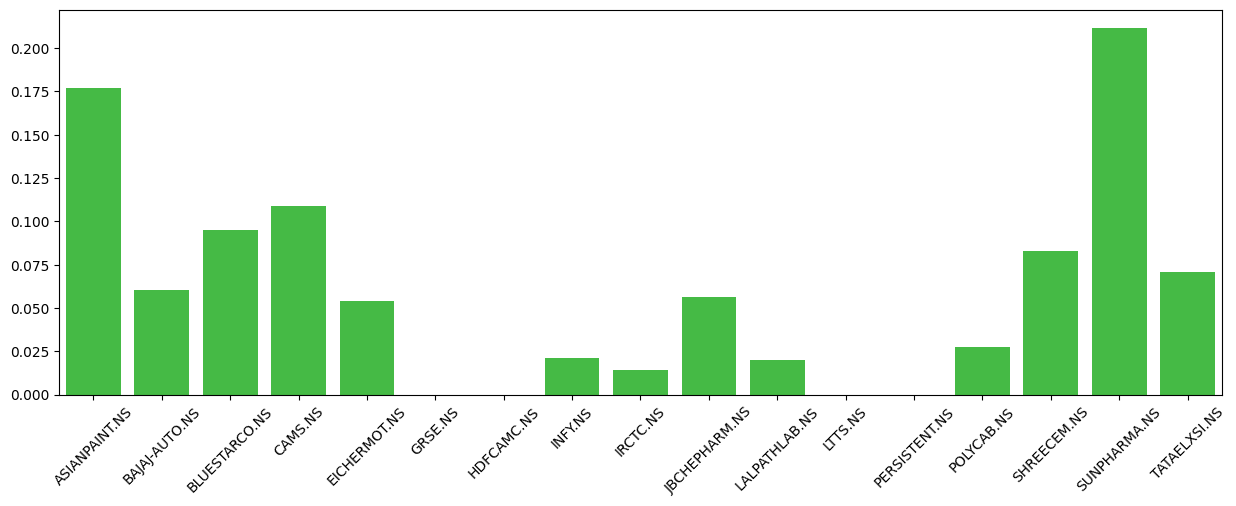

,ASIANPAINT.NS,BAJAJ-AUTO.NS,BLUESTARCO.NS,CAMS.NS,EICHERMOT.NS,GRSE.NS,HDFCAMC.NS,INFY.NS,IRCTC.NS,JBCHEPHARM.NS,LALPATHLAB.NS,LTTS.NS,PERSISTENT.NS,POLYCAB.NS,SHREECEM.NS,SUNPHARMA.NS,TATAELXSI.NS
0,0.17719,0.06041,0.0952,0.10859,0.05401,0.0,0.0,0.02106,0.01446,0.05638,0.01995,0.0,0.0,0.02764,0.08267,0.21155,0.07088


In [422]:
# Global minimum variance portfolio,no preset target return, using PyPortfolioOpt

ef=EfficientFrontier(er,S)
weights = ef.min_volatility()
   #Optimization
cleaned_weights = ef.clean_weights() #to clean the raw weights

# Get the Keys and store them in a list
labels = list(cleaned_weights.keys())
# Get the Values and store them in a list
values = list(cleaned_weights.values())

df2=pd.DataFrame([cleaned_weights.values()],columns=labels)

# Plotting the weights of the Minimum Variance Portfolio in a barplot
fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(x=labels, y=values,color="limegreen")
print('Global Minimum Variance Portfolio')
plt.xticks(rotation=45)
plt.show(fig)
df2

In [423]:
# Global Minimum Variance Portfolio Performance
ef.portfolio_performance(verbose=True)

Expected annual return: 18.3%
Annual volatility: 0.5%
Sharpe Ratio: 30.19


(0.18300472267300172, 0.005399422000860046, 30.18929112172332)

In [424]:
min_vol_ret = ef.portfolio_performance()[0]
min_vol_vol = ef.portfolio_performance()[1]
min_vol_sharpe = ef.portfolio_performance()[2]

In [425]:
print("Portfolio expected Return:",min_vol_ret.round(7))
print("Portfolio standard deviation:",min_vol_vol.round(7))
print("Portfolio SHARPE ratio:",min_vol_sharpe.round(7))

Portfolio expected Return: 0.1830047
Portfolio standard deviation: 0.0053994
Portfolio SHARPE ratio: 30.1892911


In [426]:
# Appending the results of the Global Minimum Variance Portfolio to the all_ portfolios_backtest array
all_portfolios_backtest.append(['Global Minimum Variance Portfolio', ef.portfolio_performance()[0], ef.portfolio_performance()[1], ef.portfolio_performance()[2]])

all_portfolios_backtest

[['Equal Weightage Portfolio',
  0.2823560796936469,
  0.007070984498090585,
  2.3372812613989162],
 ['Global Minimum Variance Portfolio',
  0.18300472267300172,
  0.005399422000860046,
  30.18929112172332]]

### Minimum Variance Portfolio

Calculate the minimum variance portfolio returns, while minimizing the CVar (CVar quantifies the potential extreme losses in the tail of the expected returns distribution) using PyPortfolioOpt

Minimum Variance Portfolio


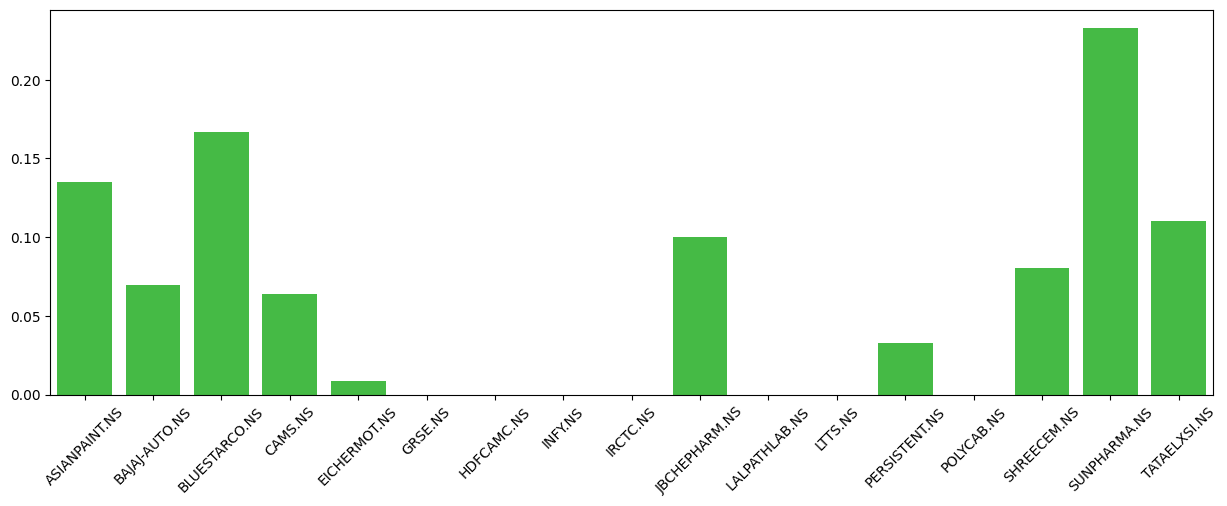

,ASIANPAINT.NS,BAJAJ-AUTO.NS,BLUESTARCO.NS,CAMS.NS,EICHERMOT.NS,GRSE.NS,HDFCAMC.NS,INFY.NS,IRCTC.NS,JBCHEPHARM.NS,LALPATHLAB.NS,LTTS.NS,PERSISTENT.NS,POLYCAB.NS,SHREECEM.NS,SUNPHARMA.NS,TATAELXSI.NS
0,0.13482,0.06981,0.167,0.06392,0.00844,0.0,0.0,0.0,0.0,0.10009,0.0,0.0,0.03259,0.0,0.0802,0.23287,0.11025


In [427]:
#3.Creating Minimum Variance Portfolio, while minimizing extreme tail loss

ef_cvar = EfficientCVaR(er,portfolio_returns) #pass expected return and portfolio returns
ef_cvar.min_cvar()
cleaned_weights = ef_cvar.clean_weights() #to clean the raw weights

# Get the Keys and store them in a list
labels = list(portfolio_returns.columns)


# Get the Values and store them in a list
values = list(cleaned_weights.values())
df3=pd.DataFrame([cleaned_weights.values()],columns=labels)
fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(x=labels, y=values,color="limegreen")
print('Minimum Variance Portfolio')
plt.xticks(rotation=45)
plt.show(fig)
df3


In [428]:
# Calculating the Returns, Risk and SHARPE Ratio of the Minimum Variance portfolio which minimizes cVaR
ef_cvar.portfolio_performance(verbose=True)
min_vol_ret = ef_cvar.portfolio_performance()[0]
min_vol_vol = ef_cvar.portfolio_performance()[1]
min_vol_sharpe = ef_cvar.portfolio_performance()[0]/ ef_cvar.portfolio_performance()[1]
print("Portfolio expected Return:",min_vol_ret.round(7))
print("Portfolio standard deviation:",min_vol_vol.round(7))
print("Portfolio SHARPE ratio:",min_vol_sharpe.round(7))

Expected annual return: 22.7%
Conditional Value at Risk: 0.98%
Portfolio expected Return: 0.2267581
Portfolio standard deviation: 0.009757
Portfolio SHARPE ratio: 23.2406617


In [429]:
# Appending the results of the Minimum Variance Portfolio (minimum CVar) to the all_ portfolios_backtest array
all_portfolios_backtest.append(['Minimum Variance Portfolio (minimum CVaR)', ef_cvar.portfolio_performance()[0], ef_cvar.portfolio_performance()[1], min_vol_sharpe])

all_portfolios_backtest

[['Equal Weightage Portfolio',
  0.2823560796936469,
  0.007070984498090585,
  2.3372812613989162],
 ['Global Minimum Variance Portfolio',
  0.18300472267300172,
  0.005399422000860046,
  30.18929112172332],
 ['Minimum Variance Portfolio (minimum CVaR)',
  0.22675812814259044,
  0.009756956629560817,
  23.240661689073978]]

### Efficient Portfolio (with targeted returns)

Calculate the efficient portfolio which will maximize for the given returns, using PyPortfolioOpt

Efficient Portfolio


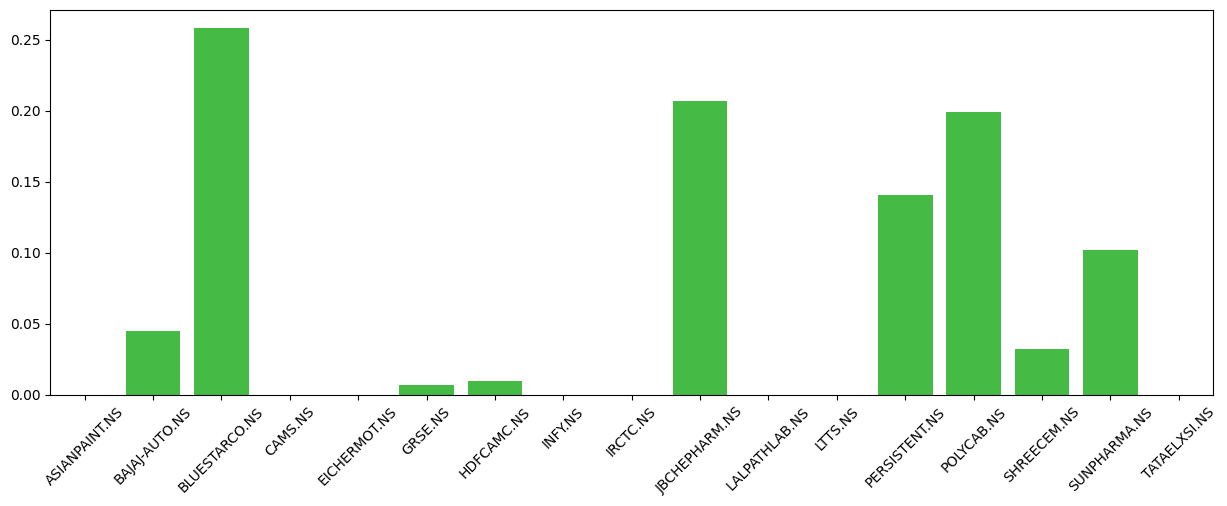

,ASIANPAINT.NS,BAJAJ-AUTO.NS,BLUESTARCO.NS,CAMS.NS,EICHERMOT.NS,GRSE.NS,HDFCAMC.NS,INFY.NS,IRCTC.NS,JBCHEPHARM.NS,LALPATHLAB.NS,LTTS.NS,PERSISTENT.NS,POLYCAB.NS,SHREECEM.NS,SUNPHARMA.NS,TATAELXSI.NS
0,0.0,0.04497,0.2582,0.0,0.0,0.0068,0.0098,0.0,0.0,0.20689,0.0,0.0,0.14023,0.19908,0.03219,0.10184,0.0


In [430]:
#4.Efficient Portfolio for a target return of 50%
ef2=EfficientCVaR(er,portfolio_returns)
ef2.efficient_return(0.50)
cleaned_weights = ef2.clean_weights() #to clean the raw weights

# Get the Keys and store them in a list
labels = list(portfolio_returns.columns)

# Get the Values and store them in a list
values = list(cleaned_weights.values())
df4=pd.DataFrame([cleaned_weights.values()],columns=labels)

# Plotting the weights of the efficient portfolio
fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(x=labels, y=values,color="limegreen")
print('Efficient Portfolio')
plt.xticks(rotation=45)
plt.show(fig)
df4

In [431]:
# Calculating the returns, risk and sharpe ratio of the efficient portfolio
ef2.portfolio_performance(verbose=True)
min_vol_ret = ef2.portfolio_performance()[0]
min_vol_vol = ef2.portfolio_performance()[1]
min_vol_sharpe = ef2.portfolio_performance()[0] / ef2.portfolio_performance()[1]
print("Portfolio expected Return:",min_vol_ret.round(7))
print("Portfolio standard deviation:",min_vol_vol.round(7))
print("Portfolio SHARPE ratio:",min_vol_sharpe.round(7))

Expected annual return: 50.0%
Conditional Value at Risk: 1.40%
Portfolio expected Return: 0.5
Portfolio standard deviation: 0.0140239
Portfolio SHARPE ratio: 35.6534604


In [432]:
# Appending the results of the Efficient Portfolio (Targeting 50% returns) to the all_ portfolios_backtest array
all_portfolios_backtest.append(['Efficient Portfolio (Tgt Return: 50%)', ef2.portfolio_performance()[0], ef2.portfolio_performance()[1], min_vol_sharpe])

all_portfolios_backtest

[['Equal Weightage Portfolio',
  0.2823560796936469,
  0.007070984498090585,
  2.3372812613989162],
 ['Global Minimum Variance Portfolio',
  0.18300472267300172,
  0.005399422000860046,
  30.18929112172332],
 ['Minimum Variance Portfolio (minimum CVaR)',
  0.22675812814259044,
  0.009756956629560817,
  23.240661689073978],
 ['Efficient Portfolio (Tgt Return: 50%)',
  0.5000000000978392,
  0.014023884218399209,
  35.65346036170519]]

### Tangency Portfolio (maximizing SHARPE Ratio)

Calculate the tangency portfolio which will maximize for the SHARPE Ratio, using PyPortfolioOpt

OrderedDict([('ASIANPAINT.NS', 0.0), ('BAJAJ-AUTO.NS', 0.1815), ('BLUESTARCO.NS', 0.16168), ('CAMS.NS', 0.0), ('EICHERMOT.NS', 0.0), ('GRSE.NS', 0.00768), ('HDFCAMC.NS', 0.02693), ('INFY.NS', 0.0), ('IRCTC.NS', 0.0), ('JBCHEPHARM.NS', 0.12239), ('LALPATHLAB.NS', 0.0), ('LTTS.NS', 0.0), ('PERSISTENT.NS', 0.08993), ('POLYCAB.NS', 0.2234), ('SHREECEM.NS', 0.09115), ('SUNPHARMA.NS', 0.09534), ('TATAELXSI.NS', 0.0)])
Tangency Portfolio 


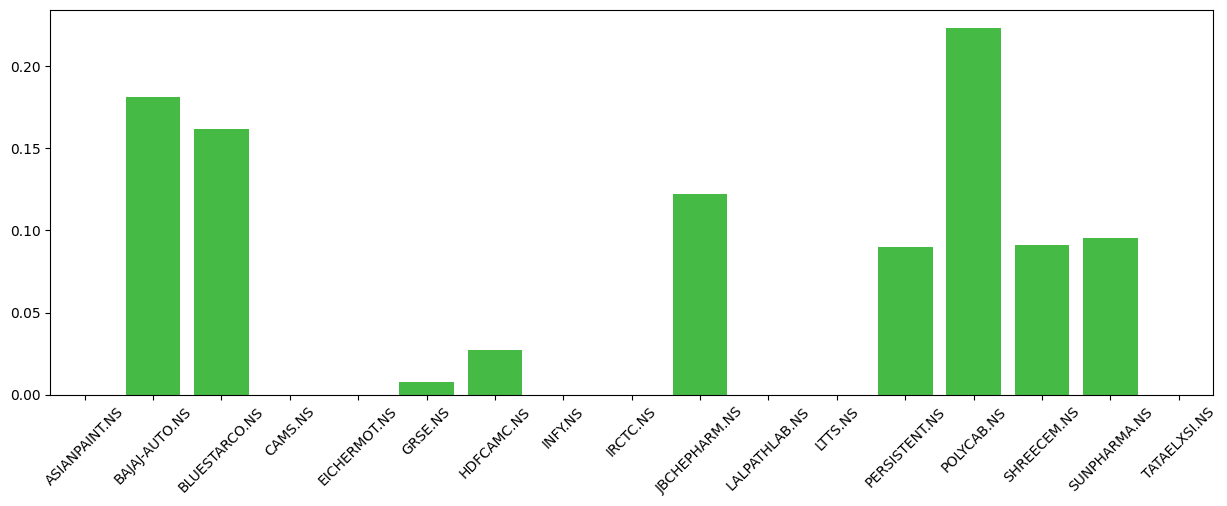

,ASIANPAINT.NS,BAJAJ-AUTO.NS,BLUESTARCO.NS,CAMS.NS,EICHERMOT.NS,GRSE.NS,HDFCAMC.NS,INFY.NS,IRCTC.NS,JBCHEPHARM.NS,LALPATHLAB.NS,LTTS.NS,PERSISTENT.NS,POLYCAB.NS,SHREECEM.NS,SUNPHARMA.NS,TATAELXSI.NS
0,0.0,0.1815,0.16168,0.0,0.0,0.00768,0.02693,0.0,0.0,0.12239,0.0,0.0,0.08993,0.2234,0.09115,0.09534,0.0


In [433]:
#5.Tangency Portfolio,Max sharpe ratio

ef = EfficientFrontier(er,S)
ef.max_sharpe(risk_free_rate=0.02) # Maximizing SHARPE based on a risk free return of 2%

print(ef.clean_weights())
cleaned_weights = ef.clean_weights() #to clean the raw weights
# Get the Keys and store them in a list
labels = list(cleaned_weights.keys())
# Get the Values and store them in a list
values = list(cleaned_weights.values())
df5=pd.DataFrame([cleaned_weights.values()],columns=labels)

# Plotting the weights as a barplot
fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(x=labels, y=values,color="limegreen")
print('Tangency Portfolio ')
plt.xticks(rotation=45)
plt.show(fig)
df5



In [434]:
# Calculating the return, risk and sharpe ratio for the tangency portfolio
ef.portfolio_performance(verbose=True)
min_vol_ret = ef.portfolio_performance()[0]
min_vol_vol = ef.portfolio_performance()[1]
min_vol_sharpe = ef.portfolio_performance()[2]
print("Portfolio expected Return:",min_vol_ret.round(7))
print("Portfolio standard deviation:",min_vol_vol.round(7))
print("Portfolio SHARPE Ratio:",min_vol_sharpe.round(7))

Expected annual return: 49.0%
Annual volatility: 0.8%
Sharpe Ratio: 61.92
Portfolio expected Return: 0.4898353
Portfolio standard deviation: 0.0075876
Portfolio SHARPE Ratio: 61.9213388


In [435]:
# Appending the results of the Tangency Portfolio (maximizing SHARPE Ratio) to the all_ portfolios_backtest array
all_portfolios_backtest.append(['Tangency Portfolio (Maximize SHARPE)', ef.portfolio_performance()[0], ef.portfolio_performance()[1], ef.portfolio_performance()[2]])

all_portfolios_backtest

[['Equal Weightage Portfolio',
  0.2823560796936469,
  0.007070984498090585,
  2.3372812613989162],
 ['Global Minimum Variance Portfolio',
  0.18300472267300172,
  0.005399422000860046,
  30.18929112172332],
 ['Minimum Variance Portfolio (minimum CVaR)',
  0.22675812814259044,
  0.009756956629560817,
  23.240661689073978],
 ['Efficient Portfolio (Tgt Return: 50%)',
  0.5000000000978392,
  0.014023884218399209,
  35.65346036170519],
 ['Tangency Portfolio (Maximize SHARPE)',
  0.4898353440838391,
  0.0075876160543890655,
  61.92133875989446]]

### Maximum Return Portfolio (with targeted risk of 1.5%)

Calculate the maximum returns portfolio which will maximize for the given returns but limiting the risk to 1.5%, using PyPortfolioOpt

Maximum Return Portfolio with target risk


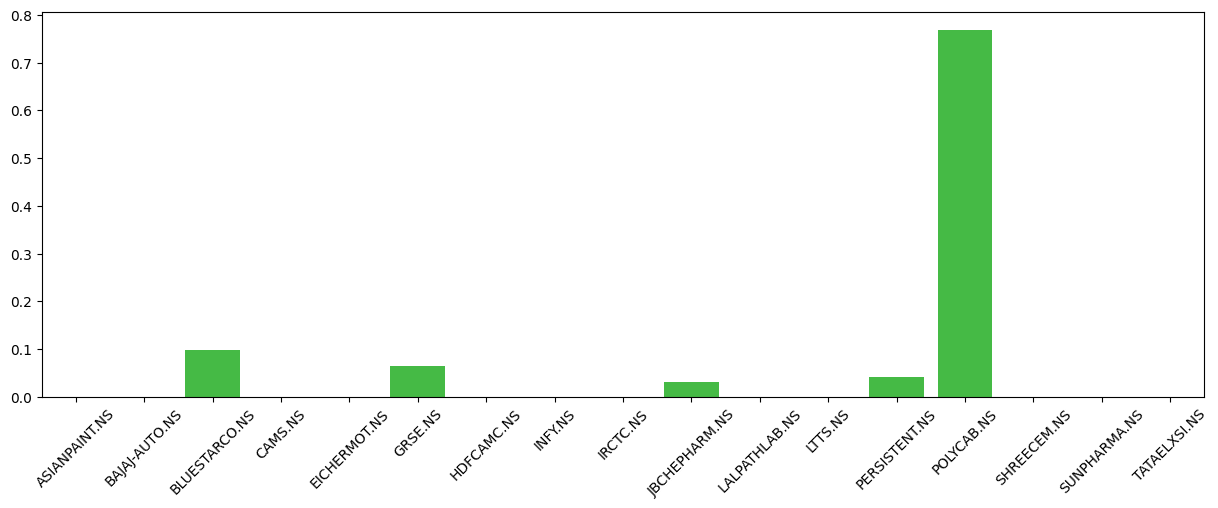

,ASIANPAINT.NS,BAJAJ-AUTO.NS,BLUESTARCO.NS,CAMS.NS,EICHERMOT.NS,GRSE.NS,HDFCAMC.NS,INFY.NS,IRCTC.NS,JBCHEPHARM.NS,LALPATHLAB.NS,LTTS.NS,PERSISTENT.NS,POLYCAB.NS,SHREECEM.NS,SUNPHARMA.NS,TATAELXSI.NS
0,0.0,0.0,0.09708,0.0,0.0,0.06398,0.0,0.0,0.0,0.02982,0.0,0.0,0.04048,0.76865,0.0,0.0,0.0


In [436]:
#6.Maximum Return Portfolio with target risk of 0.015
ef_max = EfficientFrontier(er,S)

ef_max.efficient_risk(0.015)                        #Optimization
cleaned_weights = ef_max.clean_weights()           #to clean the raw weights
# Get the Keys and store them in a list
labels = list(cleaned_weights.keys())
# Get the Values and store them in a list
values = list(cleaned_weights.values())
df6=pd.DataFrame([cleaned_weights.values()],columns=labels)

# Plotting the weights as a barplot
fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(x=labels, y=values,color="limegreen")
print('Maximum Return Portfolio with target risk')
plt.xticks(rotation=45)
plt.show(fig)
df6


In [437]:
# Calculating the return, risk and sharpe ratio for the maximum returns portfolio
ef_max.portfolio_performance(verbose=True)
min_vol_ret = ef_max.portfolio_performance()[0]
min_vol_vol = ef_max.portfolio_performance()[1]
min_vol_sharpe = ef_max.portfolio_performance()[2]
print("Portfolio expected Return:",min_vol_ret.round(7))
print("Portfolio standard deviation:",min_vol_vol.round(7))
print("Portfolio SHARPE Ratio:",min_vol_sharpe.round(7))

Expected annual return: 74.2%
Annual volatility: 1.5%
Sharpe Ratio: 48.16
Portfolio expected Return: 0.7423541
Portfolio standard deviation: 0.015
Portfolio SHARPE Ratio: 48.1569392


In [438]:
# Appending the results of the Maximum Returns Portfolio (targeting max risk of 1.5%) to the all_ portfolios_backtest array
all_portfolios_backtest.append(['Max Return Portfolio', ef_max.portfolio_performance()[0], ef_max.portfolio_performance()[1], ef_max.portfolio_performance()[2]])

all_portfolios_backtest

[['Equal Weightage Portfolio',
  0.2823560796936469,
  0.007070984498090585,
  2.3372812613989162],
 ['Global Minimum Variance Portfolio',
  0.18300472267300172,
  0.005399422000860046,
  30.18929112172332],
 ['Minimum Variance Portfolio (minimum CVaR)',
  0.22675812814259044,
  0.009756956629560817,
  23.240661689073978],
 ['Efficient Portfolio (Tgt Return: 50%)',
  0.5000000000978392,
  0.014023884218399209,
  35.65346036170519],
 ['Tangency Portfolio (Maximize SHARPE)',
  0.4898353440838391,
  0.0075876160543890655,
  61.92133875989446],
 ['Max Return Portfolio',
  0.7423540877403006,
  0.015000000000325532,
  48.1569391816416]]

### Plotting efficient Frontier and Max Sharpe Ratio

In [439]:
ef=EfficientFrontier(er,S)

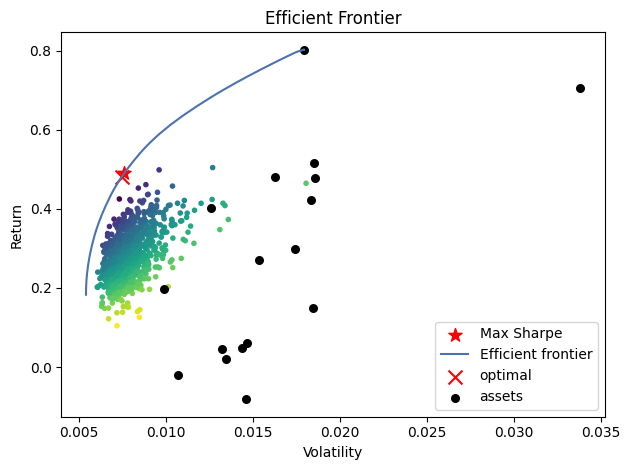

In [440]:
fig, ax = plt.subplots()

ef.max_sharpe()
# Plot the tangency portfolio or max sharpe
ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

#plotting 1000 random sub-optimal portfolios
n_samples = 1000
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)

#using critical line algorithm to plot efficient frontier
cla=CLA(er,S)
plotting.plot_efficient_frontier(cla,ax = ax,show_assets=True)

plt.show()

In [441]:
# Displaying all the different types of portfolios which were backtested
pd.DataFrame(all_portfolios_backtest, columns=['Portfolio', 'Annualized Returns', 'Annualized Risk', 'Annualized SHARPE Ratio'])

,Portfolio,Annualized Returns,Annualized Risk,Annualized SHARPE Ratio
0,Equal Weightage Portfolio,0.282356,0.007071,2.337281
1,Global Minimum Variance Portfolio,0.183005,0.005399,30.189291
2,Minimum Variance Portfolio (minimum CVaR),0.226758,0.009757,23.240662
3,Efficient Portfolio (Tgt Return: 50%),0.500000,0.014024,35.653460
4,Tangency Portfolio (Maximize SHARPE),0.489835,0.007588,61.921339
5,Max Return Portfolio,0.742354,0.015000,48.156939


#### The best returns are from the Max Returns Portfolio with an expected annualized return of 74.23%.

#### The lowest Risk is from the Global Minimum Variance Portfolio with an annualized risk of 0.54%%.

#### However, to optimize for the best expected returns basis the amount of risk we take, we make use of the SHARPE Ratio. The best SHARPE Ratio is of the Tangency Portfolio with 48.9% returns and a SHARPE Ratio of 61.9

### Calculating the Benchmark Returns and the subsequent returns for the investment date range

#### Calculating the Benchmark Returns

In [442]:
investment_start_date = "2023-10-18"
investment_end_date = "2024-10-25"

actual_returns_list = [] # Initializing a list which will store the benchmark portfolio, optimal portfolio and the GEN AI Portfolio returns to be compared later

investment_amount = 1000000000

In [443]:
# Taking the benchmark as the BSE 500 index and calculating the returns which we will take as the benchmark returns to be compared to our selected optimal portfolio (Tangency Portfolio)
benchmark_data = yf.download('BSE-500.BO', start=investment_start_date, end=investment_end_date, interval="1d")

benchmark_data['Daily_Returns'] = benchmark_data['Adj Close'].pct_change() # Daily Returns
benchmark_data = benchmark_data.dropna()

# total_return = cum_returns.iloc[-1]  # Total return at the end of the period

# Calculating the annualized returns by taking the mean of the daily returns and multiplying it by the number of trading days in our investment date range
overall_benchmark_returns = benchmark_data['Daily_Returns'].mean()*250 

# Calculating the annualized risk
tot_risk = benchmark_data['Daily_Returns'].var()
annualized_variance = tot_risk * 250

# Calculating the SHARPE Ratio
annualized_sharpe = overall_benchmark_returns / annualized_variance

# Appending to the actual_returns_list array to be compared later
actual_returns_list.append([f'Benchmark: BSE-500', overall_benchmark_returns, annualized_variance, annualized_sharpe, investment_amount*(1+overall_benchmark_returns)])


[*********************100%%**********************]  1 of 1 completed


In [444]:
actual_returns_list

[['Benchmark: BSE-500',
  0.2810336608298768,
  0.021671049081095097,
  12.968161337193344,
  1281033660.829877]]

#### Calculating the actual returns of the Minimum Variance Portfolio selected via backtesting i.e., the tangency portfolio

In [445]:

investment_data=yf.download(tickers=list(final_portfolio['Stock']),start=investment_start_date,end=investment_end_date,interval="1d")['Adj Close']

investment_data.dropna(how='any',inplace=True)

[******                12%%                      ]  2 of 17 completed

[*********************100%%**********************]  17 of 17 completed


In [446]:
# Calculating the daily stock returns of our original portfolio
StockReturns=pd.DataFrame()
StockReturns=investment_data.iloc[:,0:len(final_portfolio['Stock'])].pct_change()
StockReturns.dropna(how='any',inplace=True)

In [447]:
StockReturns

Ticker,ASIANPAINT.NS,BAJAJ-AUTO.NS,BLUESTARCO.NS,CAMS.NS,EICHERMOT.NS,GRSE.NS,HDFCAMC.NS,INFY.NS,IRCTC.NS,JBCHEPHARM.NS,LALPATHLAB.NS,LTTS.NS,PERSISTENT.NS,POLYCAB.NS,SHREECEM.NS,SUNPHARMA.NS,TATAELXSI.NS
Date,,,,,,,,,,,,,,,,,
2023-10-19,0.001728,0.067204,-0.000106,-0.021975,0.001459,-0.007429,0.001730,-0.004790,-0.005967,-0.037302,0.001298,0.003158,0.023304,-0.007820,-0.019255,-0.010317,0.012505
2023-10-20,0.001306,0.001222,-0.026423,-0.014966,-0.005798,-0.038122,0.004308,-0.004464,-0.010791,0.005567,0.001615,-0.012399,0.009976,-0.013158,-0.008092,0.000613,-0.018127
2023-10-23,-0.010899,-0.015284,-0.039487,-0.034485,-0.009926,-0.077222,-0.017385,-0.013032,-0.037422,-0.043289,-0.027591,-0.022651,-0.017106,-0.013994,-0.014589,-0.017291,-0.030135
2023-10-25,-0.003646,-0.010749,0.007758,-0.004990,-0.017976,-0.023440,-0.005567,-0.014813,-0.012233,0.007846,-0.025917,-0.001661,0.015897,-0.025416,0.000124,-0.001915,0.028461
2023-10-26,-0.032835,-0.016447,-0.031016,-0.042117,-0.017019,0.086645,-0.036275,-0.007737,-0.019755,0.009172,-0.012547,-0.016455,-0.005425,-0.030131,-0.010725,-0.014818,-0.010835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-18,-0.020845,-0.005484,0.001585,-0.022600,0.030667,0.011435,-0.003997,-0.044967,0.010611,0.003662,0.013101,-0.021059,-0.005392,-0.000021,0.003306,0.011008,-0.004942
2024-10-21,0.019067,0.043378,-0.002250,-0.020519,0.009401,0.022356,-0.022676,-0.014285,-0.025199,0.007772,-0.017669,0.024103,-0.046948,-0.038010,-0.001131,-0.006988,0.010984
2024-10-22,-0.013889,-0.012585,-0.053423,-0.052587,-0.010685,-0.127709,-0.020009,-0.000621,-0.031905,-0.002938,0.003973,-0.017609,-0.017046,-0.028950,0.005624,-0.004982,-0.038155


In [448]:
# Initializing the optimal weights (as given by the Tangency Portfolio)
optimal_weightage=np.array(df5.loc[0,:]) # Taking the weights from the Tangency Portfolio

In [449]:
optimal_portfolio=pd.DataFrame()
#Multiplying the daily stock returns and the optimal weights and summing them to get overall portfolio returns
optimal_portfolio['Portfolio_Returns'] = StockReturns.iloc[:, 0:numstocks].mul(optimal_weightage,axis=1).sum(axis=1)
# print(((investment_data.iloc[-1,:] - investment_data.iloc[0,:]) / investment_data.iloc[0,:]).mul(optimal_weightage).sum())
optimal_portfolio

,Portfolio_Returns
Date,
2023-10-19,0.005214
2023-10-20,-0.006267
2023-10-23,-0.023161
2023-10-25,-0.004486
2023-10-26,-0.016798
...,...
2024-10-18,0.000550
2024-10-21,-0.005461
2024-10-22,-0.020764


In [450]:
# Calculating the annualized returns & risk by taking the mean (& Standard Deviation) of the daily returns and multiplying it by the number of trading days in our investment date range
OP_returns = optimal_portfolio.mean()[0]*250
OP_variance = optimal_portfolio.std()[0]*250

print("Portfolio expected return:",OP_returns)
print("Portfolio standard deviation/Risk:",optimal_portfolio.std()[0])

# Calculating the SHARPE Ratio by integrating with the risk free rate
OP_sharpe = (OP_returns - risk_free_rate_daily*250) / OP_variance
print("Portfolio SHARPE Ratio:",OP_sharpe)

Portfolio expected return: 0.49635943357712214
Portfolio standard deviation/Risk: 0.010069219191600694
Portfolio SHARPE Ratio: 0.189296967190204


In [451]:
actual_returns_list.append([f'Optimal Portfolio', OP_returns, OP_variance, OP_sharpe, investment_amount*(1+OP_returns)])
actual_returns_list

[['Benchmark: BSE-500',
  0.2810336608298768,
  0.021671049081095097,
  12.968161337193344,
  1281033660.829877],
 ['Optimal Portfolio',
  0.49635943357712214,
  2.5173047979001737,
  0.189296967190204,
  1496359433.5771222]]

#### Calculating the actual returns of the Gen AI Portfolio provided by Google's Gemini LLM

In [452]:
# Calculating the actual returns of the GenAI Portfolio provided by Google's Gemini Large LanguageModel

genAI_stocks = ['RELIANCE.NS', 'HDFCBANK.NS', 'HINDUNILVR.NS', 'BAJFINANCE.NS', 'DRREDDY.NS', 'BEL.NS', 'DIXON.NS', 'HAPPSTMNDS.NS', 'IGL.NS']

genAI_investment_data=yf.download(tickers=list(genAI_stocks),start=investment_start_date,end=investment_end_date,interval="1d")['Adj Close']

genAI_investment_data.dropna(how='any',inplace=True)

[*********************100%%**********************]  9 of 9 completed


In [453]:
# Calculating the daily stock returns of the Gen AI Portfolio
StockReturns_genAI=pd.DataFrame()
StockReturns_genAI=genAI_investment_data.iloc[:,0:numstocks].pct_change()
StockReturns_genAI.dropna(how='any',inplace=True)

In [454]:
# Initializing the weights of the GenAI Portfolio (as given by the Gemini LLM)
genAI_weightage=np.array([0.20, 0.15, 0.15, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05])

In [455]:
genAI_portfolio=pd.DataFrame()
# Multiplying the daily stock returns and the optimal weights and summing them to get overall portfolio returns
genAI_portfolio['Portfolio_Returns'] = StockReturns_genAI.iloc[:, 0:len(genAI_stocks)].mul(genAI_weightage,axis=1).sum(axis=1)
# print(((genAI_investment_data.iloc[-1,:] - genAI_investment_data.iloc[0,:]) / genAI_investment_data.iloc[0,:]).mul(genAI_weightage).sum())
genAI_portfolio

,Portfolio_Returns
Date,
2023-10-19,-0.004421
2023-10-20,-0.012467
2023-10-23,-0.009632
2023-10-25,-0.003613
2023-10-26,-0.019200
...,...
2024-10-18,-0.001359
2024-10-21,-0.005758
2024-10-22,-0.018820


In [456]:
# Calculating the annualized returns & risk by taking the mean (& Standard Deviation) of the daily returns and multiplying it by the number of trading days in our investment date range
genAI_returns = genAI_portfolio.mean()[0]*250
genAI_variance = genAI_portfolio.std()[0]*250
genAI_sharpe = (genAI_returns - risk_free_rate_daily*250) / genAI_variance
print("Portfolio expected return:",genAI_returns)
print("Portfolio standard deviation/Risk:",genAI_portfolio.std()[0])

Portfolio expected return: 0.3057709117270569
Portfolio standard deviation/Risk: 0.01035702594454078


In [457]:
actual_returns_list.append([f'GenAI Portfolio', genAI_returns, genAI_variance, genAI_sharpe, investment_amount*(1+genAI_returns)])

#### Displaying and comparing the actual returns, risk, SHARPE Ratio and the final amount of our investment at the end of the investment period - 25th Oct 2024

In [458]:
# Comparing all Portfolios - 
pd.DataFrame(actual_returns_list, columns=['Portfolio', 'Returns', 'Risk', 'SHARPE Ratio', 'Final Amount'])

,Portfolio,Returns,Risk,SHARPE Ratio,Final Amount
0,Benchmark: BSE-500,0.281034,0.021671,12.968161,1.281034e+09
1,Optimal Portfolio,0.496359,2.517305,0.189297,1.496359e+09
2,GenAI Portfolio,0.305771,2.589256,0.110429,1.305771e+09


#### Calculating Alpha & Beta for the Optimal Portfolio using Linear Regression

In [459]:
optimal_data = optimal_portfolio[['Portfolio_Returns']].merge(benchmark_data[['Daily_Returns']], left_index=True, right_index=True)
# optimal_data

In [460]:
risk_free_rate = 0.02 / 250
optimal_data['Excess Portfolio Returns'] = optimal_data['Portfolio_Returns'] - risk_free_rate
optimal_data['Excess Benchmark Returns'] = optimal_data['Daily_Returns'] - risk_free_rate

X = optimal_data['Excess Benchmark Returns']
y = optimal_data['Excess Portfolio Returns']

# Add a constant to the independent variable to represent the intercept (alpha)
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Extract alpha and beta
alpha_optimal = model.params['const']
beta_optimal = model.params['Excess Benchmark Returns']

print("Alpha for Optimal Portfolio:", alpha_optimal)
print("Beta for Optimal Portfolio:", beta_optimal)

Alpha for Optimal Portfolio: 0.0011598445700503907
Beta for Optimal Portfolio: 0.7412093743310013


#### Calculating Alpha & Beta for the Gen AI Portfolio using Linear Regression

In [461]:
genAI_data = genAI_portfolio[['Portfolio_Returns']].merge(benchmark_data[['Daily_Returns']], left_index=True, right_index=True)
# genAI_data

In [462]:
risk_free_rate = 0.02 / 250
genAI_data['Excess Portfolio Returns'] = genAI_data['Portfolio_Returns'] - risk_free_rate
genAI_data['Excess Benchmark Returns'] = genAI_data['Daily_Returns'] - risk_free_rate

X = genAI_data['Excess Benchmark Returns']
y = genAI_data['Excess Portfolio Returns']

# Add a constant to the independent variable to represent the intercept (alpha)
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Extract alpha and beta
alpha_genAI = model.params['const']
beta_genAI = model.params['Excess Benchmark Returns']

print("Alpha for Gen AI Portfolio:", alpha_genAI)
print("Beta for Gen AI Portfolio:", beta_genAI)

Alpha for Gen AI Portfolio: 0.00012259235896686934
Beta for Gen AI Portfolio: 0.988725945317216
